### Facial Landmarks
#### Get the data

In [ ]:
%%bash

export KAGGLE_USERNAME=ilyabasharov
export KAGGLE_KEY=db21bf4cd9d1915c6a467aff8a30f245
kaggle competitions download -c made-cv-2021-contest-01-facial-landmarks
unzip -q made-cv-2021-contest-01-facial-landmarks.zip
rm made-cv-2021-contest-01-facial-landmarks.zip

#### Structure of the dataset

- contest01_data
    - train
        - images
            filename.jpg
        - landmarks.csv
            (filename.jpg point{i}_x, point{i}_y for i in range(971))
    - test
        - images
            filename.jpg
        - test_points.csv
            (filename.jpg test_points{i} for i in range(30))
    

In [ ]:
!nvidia-smi

### Import Libraries

In [1]:
import torch
from tqdm.notebook import tqdm
from collections import defaultdict
from torchvision import transforms

from utils.transforms import (
    ScaleMinSideToSize,
    CropCenter,
    TransformByKeys,
    Cutout,
    UnNormalize,
    RandomLandmarksRotation,
)

from utils.loss import WingLoss
from utils.collector import Collector
from utils.model import (
    getModelTorchvision,
    getModelTIMM,
)
from utils.dataset import ThousandLandmarksDataset

### Random seed

In [2]:
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Define training function

In [3]:
def trainer(
    model,
    optimizer,
    scheduler,
    dataloaders_dict,
    num_epochs,
    device,
    loss_function,
    visualiser,
):
    
    loss_per_epoch = defaultdict(list)
    min_val_loss = 1e10
    
    for epoch in range(num_epochs):
        
        loss_per_batch = defaultdict(list)
        
        for phase in dataloaders_dict:
            
            phase_train = phase == 'train'
            
            model.train() if phase_train else model.eval()
            
            for batch in tqdm(dataloaders_dict[phase], desc = phase):
                images = batch['image'].to(device)      # B x 3 x CROP_SIZE x CROP_SIZE
                gt     = batch['landmarks'].to(device)  # B x (2 * NUM_PTS)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase_train):
                    
                    preds = model(images)
                    batch_loss = loss_function(preds, gt)
                    
                    if phase_train:
                        batch_loss.backward()
                        optimizer.step()
                        
                        scheduler.step()
                    
                    loss_per_batch[phase].append(batch_loss.item())
                    
            loss_per_epoch[phase].append(
                sum(loss_per_batch[phase]) / len(dataloaders_dict[phase].dataset)
            )
            
        
        if loss_per_epoch['val'][-1] < min_val_loss:
            min_val_loss = loss_per_epoch['val'][-1]
            torch.save(model.state_dict(), 'model.pth')
            
        if visualiser is not None:
            visualiser.step(loss_per_epoch)
            

### Global constants

In [7]:
bs = 64
num_points = 971
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone_type = 'resnext101_32x8d'
crop_size = 256
train_size = 0.9

root_dir = 'contest01_data/train'
test_dir = 'contest01_data/test'
mean = [0.5, 0.5, 0.5]
std = [0.25, 0.25, 0.25]
epochs = 20

print('Device is', device)

Device is cuda


### Transformations

In [5]:
transformations = {
    'train': transforms.Compose([
        ScaleMinSideToSize((crop_size, crop_size)),
        CropCenter(crop_size),
        TransformByKeys(transforms.ToPILImage(), ('image',)),
        RandomLandmarksRotation(20),
        TransformByKeys(transforms.ToTensor(), ('image',)),
        TransformByKeys(transforms.Normalize(mean, std, True), ('image',)),
        transforms.RandomApply([
            Cutout(2, 30),
        ], p=0.3)
    ]),
    
    'val': transforms.Compose([
        ScaleMinSideToSize((crop_size, crop_size)),
        CropCenter(crop_size),
        TransformByKeys(transforms.ToPILImage(), ('image',)),
        TransformByKeys(transforms.ToTensor(), ('image',)),
        TransformByKeys(transforms.Normalize(mean, std, True), ('image',)),
    ]),
}

### Define dataloaders

In [6]:
datasets = {
    phase: ThousandLandmarksDataset(
        root=root_dir,
        transforms=transformations[phase],
        split=phase,
        train_size=train_size
    )
    for phase in transformations
}

dataloaders = {
    phase: torch.utils.data.DataLoader(
        dataset=datasets[phase],
        batch_size=bs,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
        
    )
    for phase in transformations
}

In [15]:
test_dataset = ThousandLandmarksDataset(
    test_dir,
    transformations['val'],
    split='test',
)

### Define utils

In [8]:
model = getModelTorchvision(backbone_type, num_points*2, device)
best_state_dict = torch.load('model_resnext101_32x8d.pth', map_location='cuda')
model.load_state_dict(best_state_dict)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=1e-4, steps_per_epoch=898, epochs=epochs)
loss_function = WingLoss()
visualiser = Collector('metrics/resnext101_32x8d', 'metrics/resnext101_32x8d', transformations)

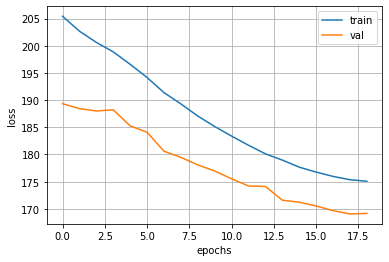

train:   0%|          | 0/898 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
trainer(model, optim, scheduler, dataloaders, epochs, device, loss_function, visualiser)

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

#### Visualisation of train batch

In [11]:
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

In [12]:
def visualize_prediction(model, dataset, num_points, mean, std, indexes=None):
    
    plt.figure(figsize=(26, 10))
    
    unnorm = UnNormalize(mean, std)
    model.eval()

    for i in range(10):
        if indexes is not None:
            index = indexes[i]
        else:
            index = random.randint(0, len(dataset))
            
        sample = dataset[index]
        
        with torch.no_grad():
            pred_landmarks = model(sample['image'].cuda().unsqueeze(0)).squeeze(0).cpu().numpy().reshape((num_points, 2))
        
        image = (unnorm(sample['image']).permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        image = image.copy()
        
        if 'landmarks' in sample:
            landmarks = sample['landmarks'].numpy().reshape((num_points, 2))
            
            for point in landmarks:
                x, y = point.astype(np.int)
                cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
        
        for point in pred_landmarks:
            x, y = point.astype(np.int)
            cv2.circle(image, (x, y), 1, (170, 50, 50), 1, -1)
            
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(i), fontsize=15)
        plt.imshow(image);

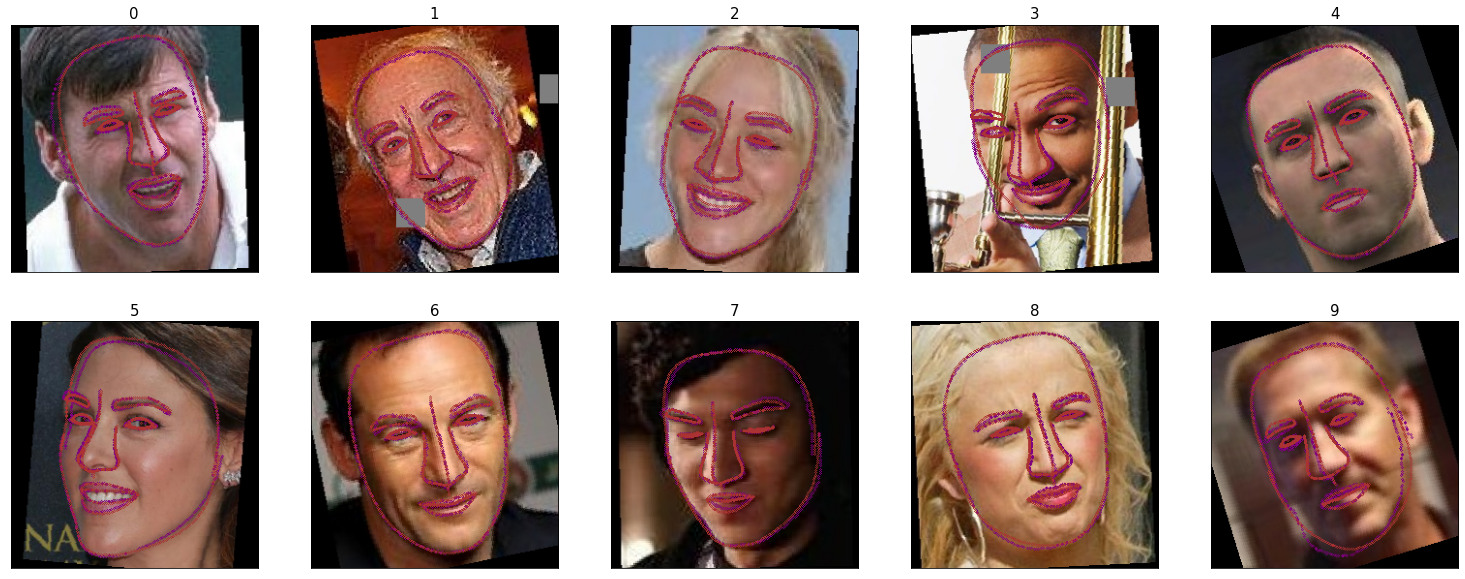

In [13]:
visualize_prediction(model, datasets['train'], num_points, mean, std)

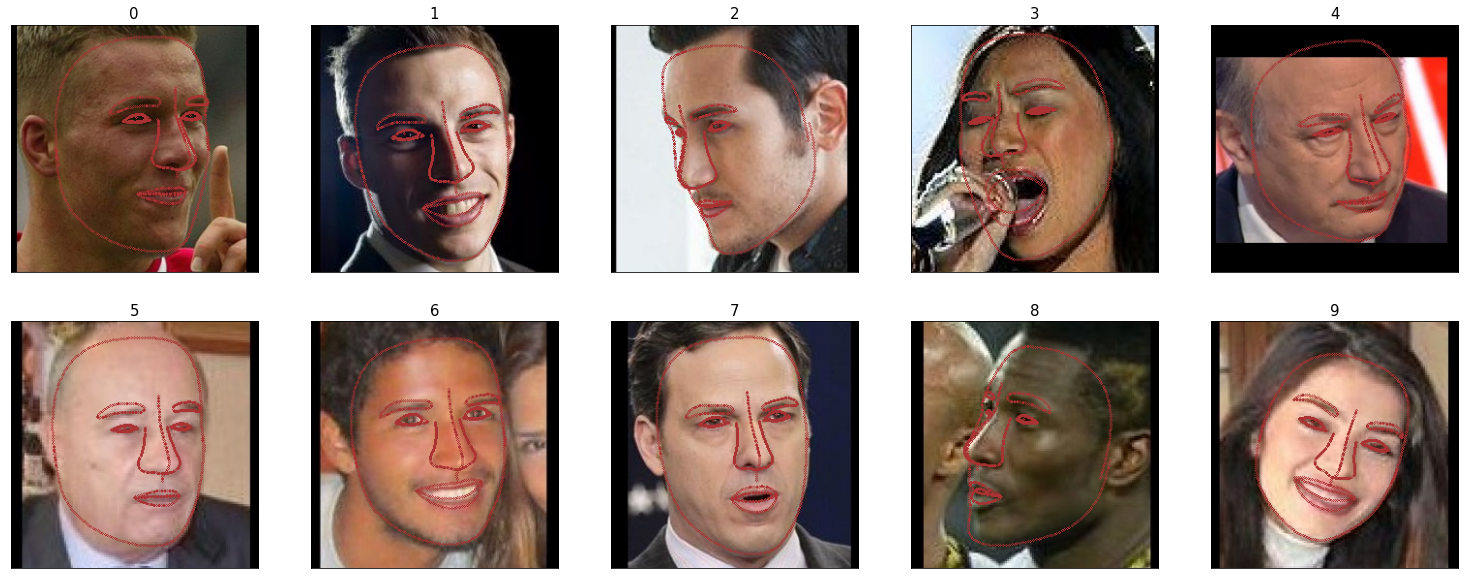

In [16]:
visualize_prediction(model, test_dataset, num_points, mean, std)

### Create predictions

In [17]:
from utils.submission import submit 

In [18]:
submit(model, transformations['val'], 'contest01_data/test', 'submission.csv', device, num_points)

evaluation:   0%|          | 0/4000 [00:00<?, ?it/s]

### How to clear the dataset ?

- Let's remove images from the dataset which have incorrect layout using loss evaluation

In [ ]:
all_data = ThousandLandmarksDataset(
    root=root_dir,
    transforms=transformations['val'],
    split='train',
    train_size=1.0
)
all_dataloader = torch.utils.data.DataLoader(
    dataset=all_data,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
)

In [ ]:
losses, idxs = [], []
for batch in tqdm(all_dataloader, desc = 'Collect loss'):
    images = batch['image'].to(device)      # B x 3 x CROP_SIZE x CROP_SIZE
    gt     = batch['landmarks'].to(device)  # B x (2 * NUM_PTS)
    
    with torch.no_grad():
        preds = model(images)
    batch_loss = loss_function(preds, gt)

    losses.append(batch_loss.item())
    idxs.append(batch['idx'].item())

#### Plot histogram of losses

In [ ]:
plt.figure(figsize=(26, 10))
plt.hist(losses, bins=500);
plt.xticks(np.arange(min(losses), max(losses) + 1, 3.0));

In [ ]:
losses = np.array(losses)
idxs = np.array(idxs)

strange_idxs = idxs[losses > 20]
print(len(strange_idxs))

In [ ]:
visualize_prediction(model, all_data, num_points, mean, std, strange_idxs)